In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import time
import requests

# Récupération et nettoyage des données

In [308]:
import time
url = 'http://www.theses.fr/?q=&format=json&start={}'
json_list = []
for i in range(0,482860,1000):
    r = requests.get(url.format(i))
    data = r.json()["response"]["docs"]
    json_list += data
    time.sleep(1)
    print(i)
df = pd.json_normalize(json_list)
df.to_csv("theses.csv",index=False)

In [2]:

# pour lire les colonnes de liste au bon format
def generic(x):
    if x =="":
        x = "['0']"
    
    a = ast.literal_eval(x)
    return a


conv = {"personne" : generic,
        "ppn" : generic,
        "oaiSetSpec" : generic,
        "directeurThesePpn" : generic,
        "directeurTheseNP" : generic,
        "directeurThese" : generic,
        "etablissement" : generic
       }

dates = ['sujDatePremiereInscription',"dateSoutenance"]

df = pd.read_csv("all_theses2.csv",converters=conv, parse_dates=dates,dtype={"id" : str})

# récupération des codes Domaine
codes = pd.read_html("https://www.theses.fr/schemas/tef/recommandation/oai_sets.html")[0][[0,1]]
dic_codes = {}
for A, B in zip(codes[1], codes[0]):
    dic_codes[A] = B

    
df["oaiSetSpec"] =df["oaiSetSpec"].apply(lambda x : [dic_codes[i] for i in x if i != "0"])
df = df[~df["oaiSetSpec"].astype(str).str.contains("Médecine et santé",case=False).fillna(False)]
df = df[(df["dateSoutenance"].dt.year > 1985) & (df["dateSoutenance"].dt.year < 2020)]
df = df.rename(columns={"oaiSetSpec" : "domaine"})

/home/riri/miniconda3/envs/base_data/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [182]:
df.head()[["titre","auteur","discipline","domaine","directeurThese","etablissement","dateSoutenance"]]

,titre,auteur,discipline,domaine,directeurThese,etablissement,dateSoutenance
3,Mesures de la conductivité thermique de fluide...,Farel Hasiholan Napitupulu,Génie des procédés industriels,"[Chimie, minéralogie, cristallographie, Scienc...",[Gérard Antonini],[Compiègne],1988-01-01 23:59:59+00:00
4,Fiscalité et promotion des exportations de bie...,Martine Arnaud,Sciences économiques,[Economie],[Jean-Paul Azam],[Clermont-Ferrand 1],1994-01-01 23:59:59+00:00
5,L'effet d'éviction financier dans les pays en ...,Philippe Messeant,Sciences économiques,[Economie],[Sylviane Guillaumont],[Clermont-Ferrand 1],1993-01-01 23:59:59+00:00
16,Caractérisation par fibre optique des hétérogé...,Hugo Le lay,Sciences de la Terre,"[Astronomie, cartographie, géodésie]",[Florentina Moatar-bertrand],[Tours],2019-04-19 23:59:59+00:00
51,Variabilité de réponse aux stress multiples ch...,Quentin Petitjean,Ecologie fonctionnelle,[Animaux. Zoologie],"[Lisa Jacquin, Pascal Laffaille]",[Toulouse 3],2019-12-17 23:59:59+00:00


# analyse

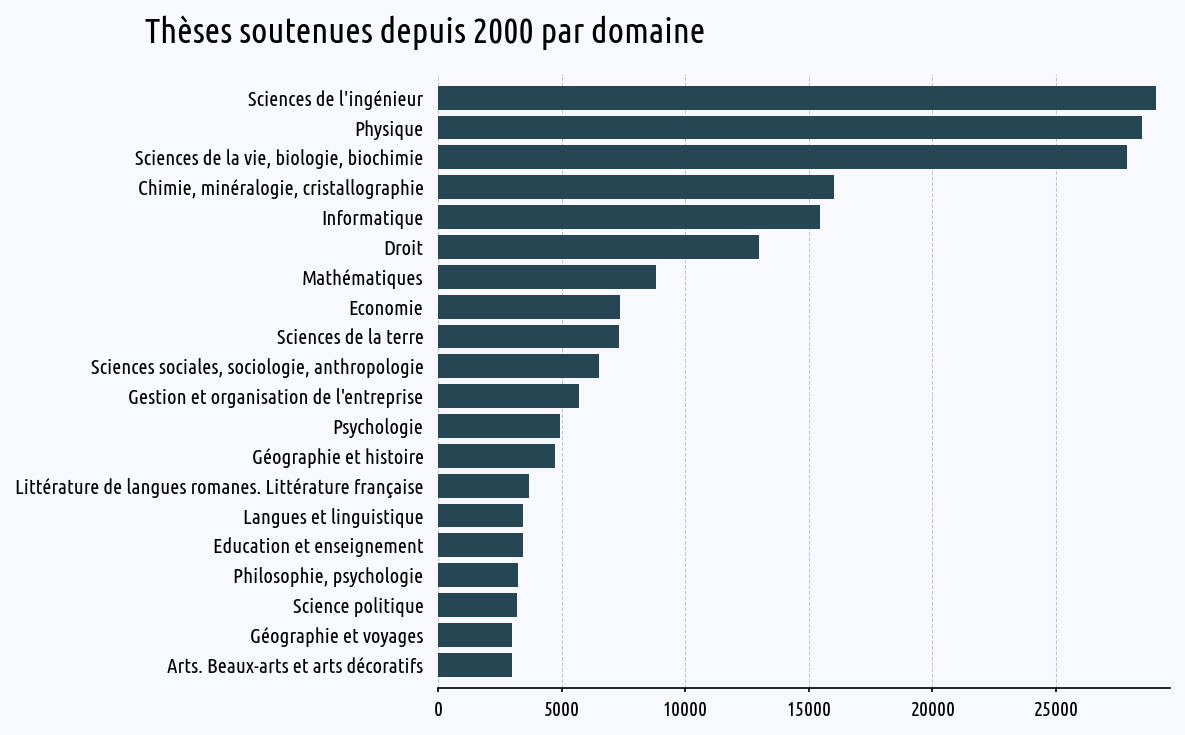

In [149]:
#nombre de thèses depuis 2000 par domaine
data = df[df["dateSoutenance"].dt.year > 2000]
data = data["domaine"].explode().value_counts()[:20].sort_values()
with plt.style.context("rirO"):
    x= data.index
    y = data.values
    plt.barh(x,y,zorder=3)
    plt.grid(None)
    plt.title("Thèses soutenues depuis 2000 par domaine",x=-0.4)
    plt.savefig("theses_par_domaine.png")

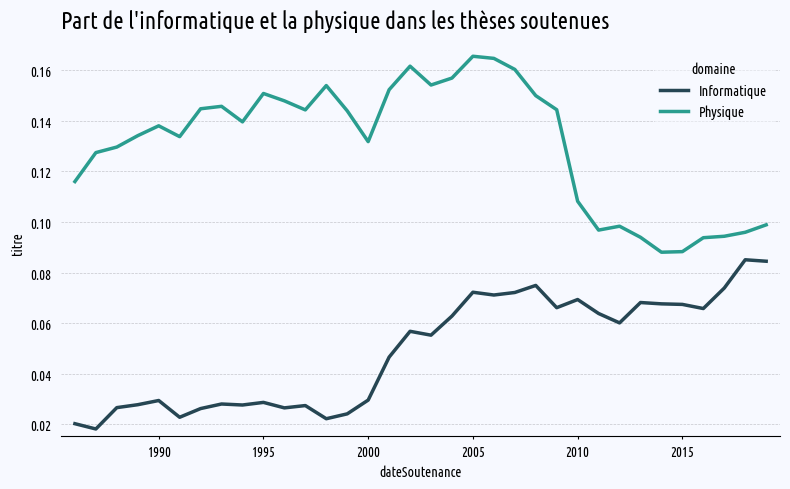

In [193]:
# Montée en puissance de l'informatique
nb_domaines = df.groupby([df["dateSoutenance"].dt.year,df["domaine"].apply(lambda x : x[0] if len(x)>0 else "NaN")])["titre"].count()
nb_total = nb_domaines.groupby("dateSoutenance").transform("sum")
domains_share  = nb_domaines/nb_total

data = domains_share.loc[:,["Informatique","Physique"]].reset_index()
with plt.style.context("rirO"):
    
    sns.lineplot(data=data,x="dateSoutenance",y="titre",hue="domaine")
    plt.title("Part de l'informatique et la physique dans les thèses soutenues")

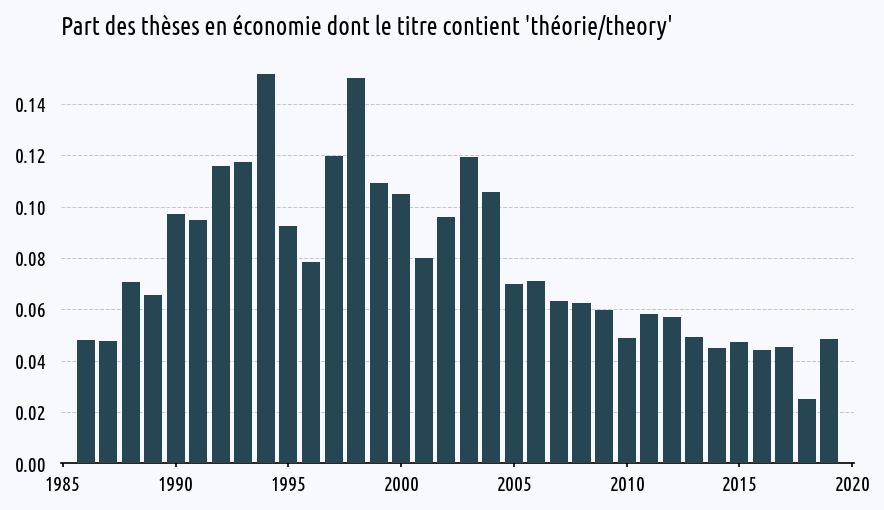

In [375]:
df_soc = df[df["oaiSetSpec"].apply(lambda x : "Economie" in x)]
data = df_soc[df_soc["titre"].str.contains("theor|théor",case=False)]
data = data.groupby(data["dateSoutenance"].dt.year)["dateSoutenance"].count()
nb_soc = df_soc.groupby(df_soc["dateSoutenance"].dt.year)["dateSoutenance"].count()
data = data/nb_soc
with plt.style.context("rirO"):
    fig,ax = plt.subplots(figsize=(6,3.5))
    ax.bar(data.index,data.values,zorder=3)
    ax.set_title("Part des thèses en économie dont le titre contient 'théorie/theory'", fontsize=12)
    fig.savefig("theorie_part.png")

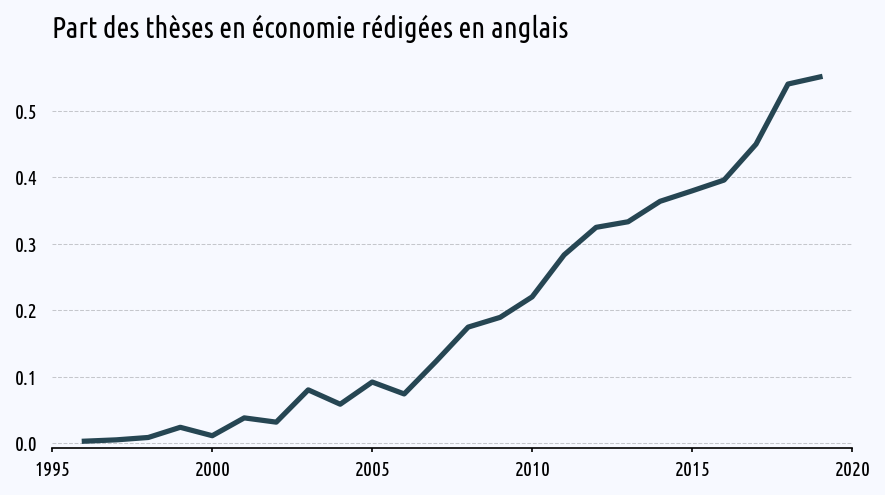

In [402]:
# pct de thèses en anglais
nb_en = df[(df["oaiSetSpec"].apply(lambda x : "Economie" in x)) & (df["langueThese"].str.contains("en").fillna(False)) ].groupby(df["dateSoutenance"].dt.year)["dateSoutenance"].count().rename("nb_en")
nb_info = df[(df["oaiSetSpec"].apply(lambda x : "Economie" in x))].groupby(df["dateSoutenance"].dt.year)["dateSoutenance"].count().rename("nb_tot")
pct_en = nb_en/nb_info

with plt.style.context("rirO"):
    
    fig,ax = plt.subplots(figsize=(6,3.4))
    plt.rcParams['axes.labelsize'] = 200
    ax.plot(pct_en.index,pct_en.values)
    ax.set(xlim=(1995,2020))
    ax.set_title("Part des thèses en économie rédigées en anglais",fontsize=14)
    
    fig.savefig("econ_anglais.png")

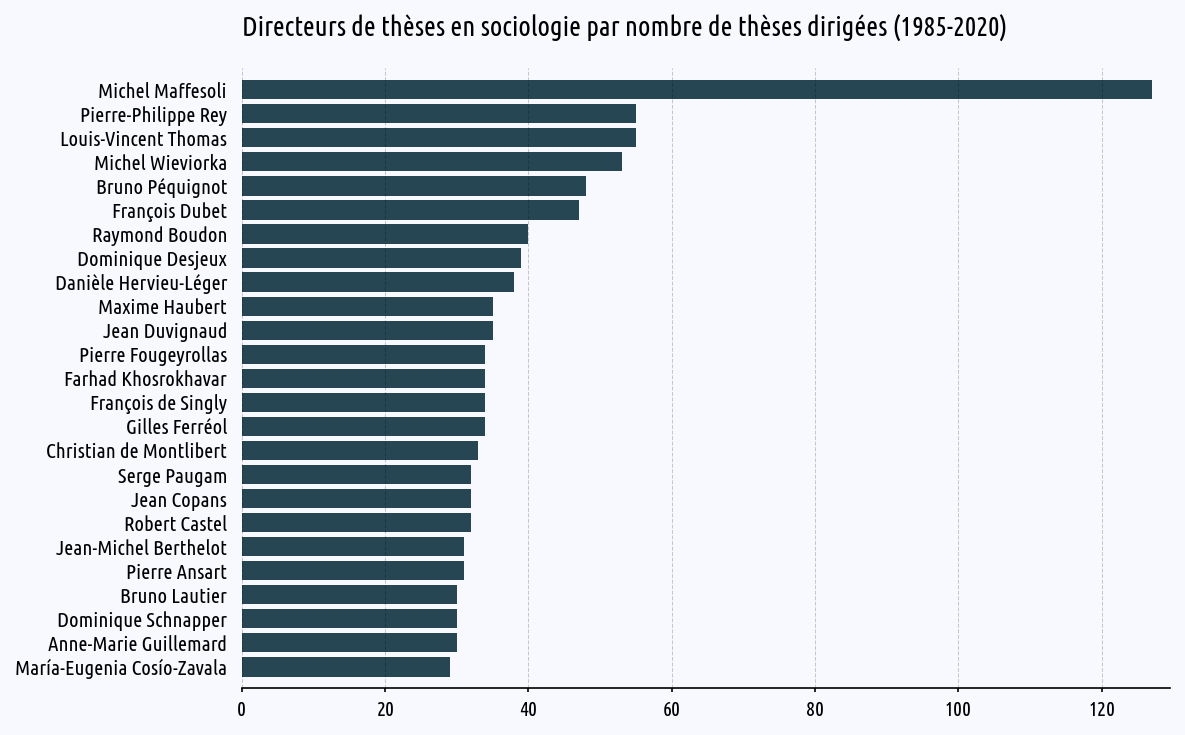

In [425]:
df_soc = df[df["discipline"].str.contains("sociologie",case=False)]
dirs = df_soc["directeurThese"].explode().value_counts()[:25]

with plt.style.context("rirO"):
    plt.rcParams['axes.labelsize'] = 12
    plt.barh(dirs.index,dirs.values)
    plt.gca().invert_yaxis()
    plt.grid(None)
    plt.title("Directeurs de thèses en sociologie par nombre de thèses dirigées (1985-2020)",fontsize=13)
    

<ipython-input-191-5ea75e43ceb8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dates["diff"] = (df["dateSoutenance"] - df["sujDatePremiereInscription"]).dt.days
/home/riri/miniconda3/envs/base_data/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'durée de la thèse en jours')

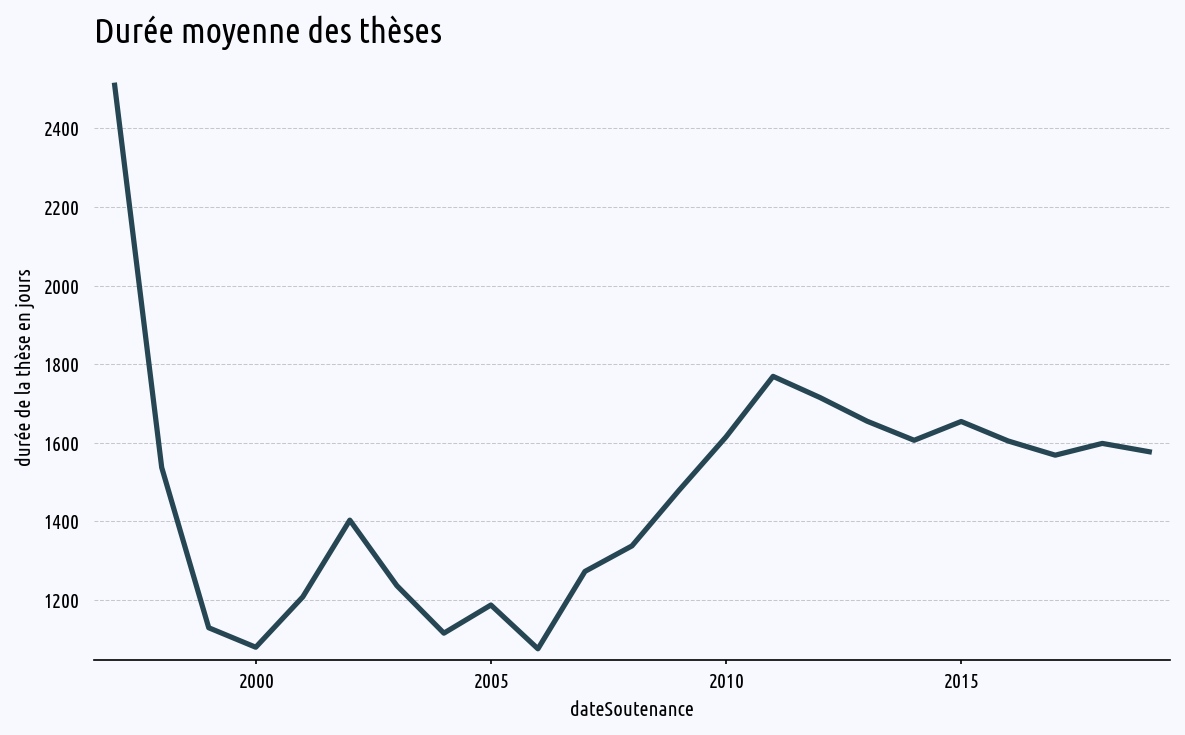

In [191]:
# durée des thèses, mais je pense que les données sont trop mauvaises pour en déduire quelque chose
plt.style.reload_library()
df_dates = df[(df["sujDatePremiereInscription"].notna()) & (df["dateSoutenance"].notna())]
df_dates["diff"] = (df["dateSoutenance"] - df["sujDatePremiereInscription"]).dt.days
df_dates = df_dates.dropna(subset=["diff"])
a = df_dates.groupby(df_dates["dateSoutenance"].dt.year)["diff"].mean()
sns.lineplot(a.index,a.values)
plt.title("Durée moyenne des thèses")
plt.ylabel("durée de la thèse en jours")